## Cortical GMM analyses across NMF factors from slices 0259, 0359

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numpy.random import choice
from scipy.spatial.distance import jensenshannon
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage.io import imread, imsave
from skimage.transform import rotate
from skimage.morphology import binary_erosion
from skimage.morphology.selem import disk

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from padpatch import padPatch as patch
from img_overlay import img_overlay

#### Load representations and full slice masks

In [4]:
im_0259 = imread('XZ_Reslice_VS0172_fullstack_cc_rot_crop0259.tif')
im_0359 = imread('XZ_Reslice_VS0172_fullstack_cc_rot_crop0359.tif')

In [5]:
mask_0259 = np.load('usual_order_annos_noTRN_0259.npy')
mask_0359 = np.load('usual_order_annos_noTRN_0359.npy')

In [6]:
ctx_mask_0259_full = mask_0259==1
ctx_mask_0359_full = mask_0359==1

In [7]:
ctx_info_0259 = np.load('final_ctx_reps_labels_with_positions_0259.npy')
ctx_info_0359 = np.load('final_ctx_reps_labels_with_positions_0359.npy')

#### Divide into features, locations

In [8]:
def info2feats(info):
    return info[:,:-3], info[:,-3:-1], info[:,-1]

In [9]:
feats_ctx_0259, locs_ctx_0259, _ = info2feats(ctx_info_0259)
feats_ctx_0359, locs_ctx_0359, _ = info2feats(ctx_info_0359)

#### Load NMFs

In [10]:
nmf_0259 = np.load('NNMF_15D_0259.npy')
nmf_0359 = np.load('NNMF_15D_0359.npy')

In [11]:
nmf_ctx_0259 = nmf_0259[:len(feats_ctx_0259),:]
nmf_ctx_0359 = nmf_0359[:len(feats_ctx_0359),:]

#### Erode mask to get rid of CTX outliers

In [12]:
mask_0259_binary = (mask_0259>0)*1
mask_0359_binary = (mask_0359>0)*1

In [13]:
def maskEroder(img_mask,dd=64):
    img_mask_eroded = np.zeros_like(img_mask)
    for ii in range(6):
        mm = (img_mask==(ii+1))
        eroded_area = binary_erosion(mm,disk(dd))
        img_mask_eroded += eroded_area*(ii+1)
    return img_mask_eroded

In [14]:
eroded_mask_0259 = maskEroder(mask_0259_binary)
eroded_mask_0359 = maskEroder(mask_0359_binary)

In [15]:
eroded_ctx_mask_0259 = (eroded_mask_0259*mask_0259 ==1)*1
eroded_ctx_mask_0359 = (eroded_mask_0359*mask_0359 == 1)*1
eroded_ctx_locs_0259 = np.zeros((np.sum(eroded_ctx_mask_0259),2))
eroded_ctx_locs_0359 = np.zeros((np.sum(eroded_ctx_mask_0359),2))

In [16]:
eroded_ctx_locs_0259[:,0] = np.where(eroded_ctx_mask_0259>0)[0]
eroded_ctx_locs_0259[:,1] = np.where(eroded_ctx_mask_0259>0)[1]
eroded_ctx_locs_0359[:,0] = np.where(eroded_ctx_mask_0359>0)[0]
eroded_ctx_locs_0359[:,1] = np.where(eroded_ctx_mask_0359>0)[1]

In [17]:
def rearrangeFeats(feats,locs):
    feats_tensor = np.zeros((1420,5805,15))
    for ii in range(len(feats)):
        r,c = locs[ii].astype(int)
        feats_tensor[r,c,:] = feats[ii]
    return feats_tensor

In [18]:
nmf_feats_ctx_tensor_0259 = rearrangeFeats(nmf_ctx_0259,locs_ctx_0259)
nmf_feats_ctx_tensor_0359 = rearrangeFeats(nmf_ctx_0359,locs_ctx_0359)

In [19]:
def tensorFeats2featsEroded(feats_tensor,eroded_locs):
    feats_eroded_mat = np.zeros((len(eroded_locs),15))
    for ii in range(len(eroded_locs)):
        r,c = eroded_locs[ii].astype(int)
        feats_eroded_mat[ii] = feats_tensor[r,c]
    return feats_eroded_mat

In [20]:
eroded_nmf_ctx_0259 = tensorFeats2featsEroded(nmf_feats_ctx_tensor_0259,eroded_ctx_locs_0259)
eroded_nmf_ctx_0359 = tensorFeats2featsEroded(nmf_feats_ctx_tensor_0359,eroded_ctx_locs_0359)

#### GMM

In [21]:
def gmm_reps(feats,locs,nc=4):
    gmm = GaussianMixture(n_components=nc,random_state=22)
    gmm_labels = gmm.fit_predict(feats)
    gmm_proba = gmm.predict_proba(feats)
    
    gmm_stack = np.zeros((nc,1420,5805))
    for ii in range(nc):
        for jj in range(len(locs)):
            r,c = locs[jj].astype(int)
            gmm_stack[ii,r,c] = gmm_proba[jj,ii]
        
    return gmm_stack

In [22]:
gmm_stack_0259 = gmm_reps(eroded_nmf_ctx_0259,eroded_ctx_locs_0259,nc=4)

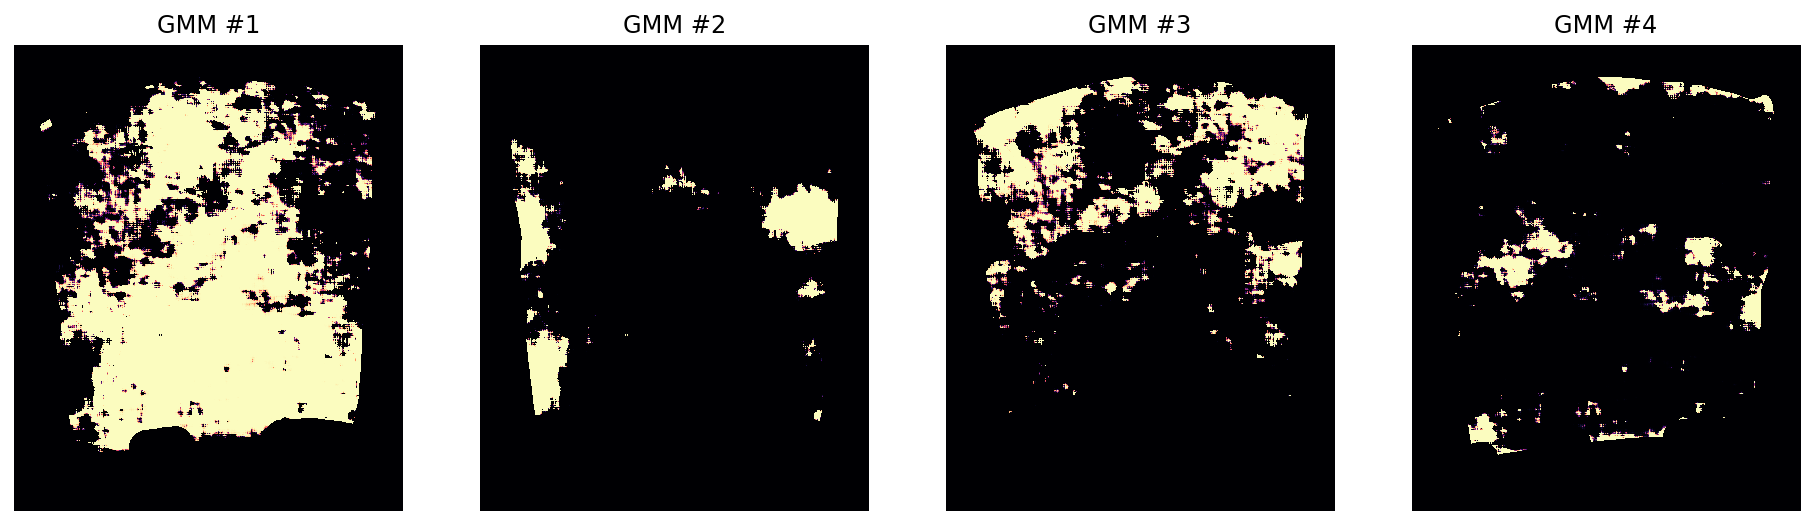

In [23]:
nn = len(gmm_stack_0259)
ff = plt.figure(figsize=(16,5))
for ii in range(nn):
    plt.subplot(1,nn,ii+1)
    plt.imshow(np.flipud(gmm_stack_0259[ii,:,4100:].T),cmap='magma')
    plt.axis('off')
    plt.title('GMM #'+str(ii+1))

(-0.5, 1419.5, 1704.5, -0.5)

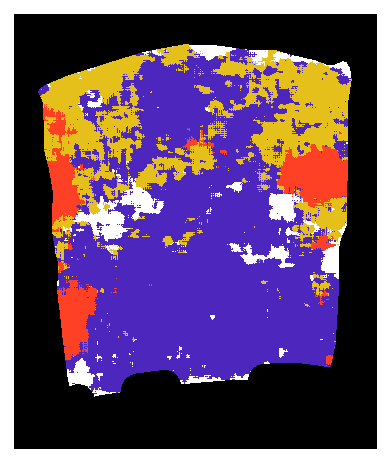

In [24]:
gmm_stack_0259_preds = np.argmax(gmm_stack_0259,axis=0) + 1
gmm_stack_0259_preds *= eroded_ctx_mask_0259
plt.imshow(np.flipud(gmm_stack_0259_preds[:,4100:].T),cmap='CMRmap')
plt.axis('off')

(-0.5, 1419.5, 1704.5, -0.5)

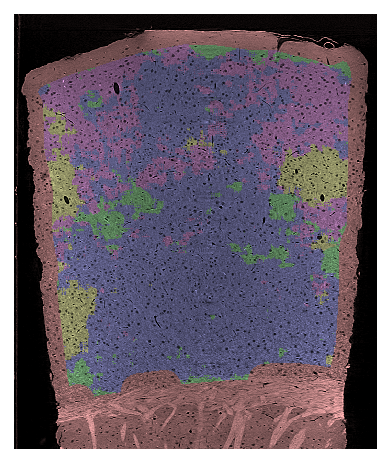

In [31]:
plt.imshow(np.flipud(img_overlay(gmm_stack_0259_preds[:,4100:].T,im_0259[:,4100:].T,0.3)))
plt.axis('off')

In [25]:
gmm_stack_0359 = gmm_reps(eroded_nmf_ctx_0359,eroded_ctx_locs_0359,nc=4)

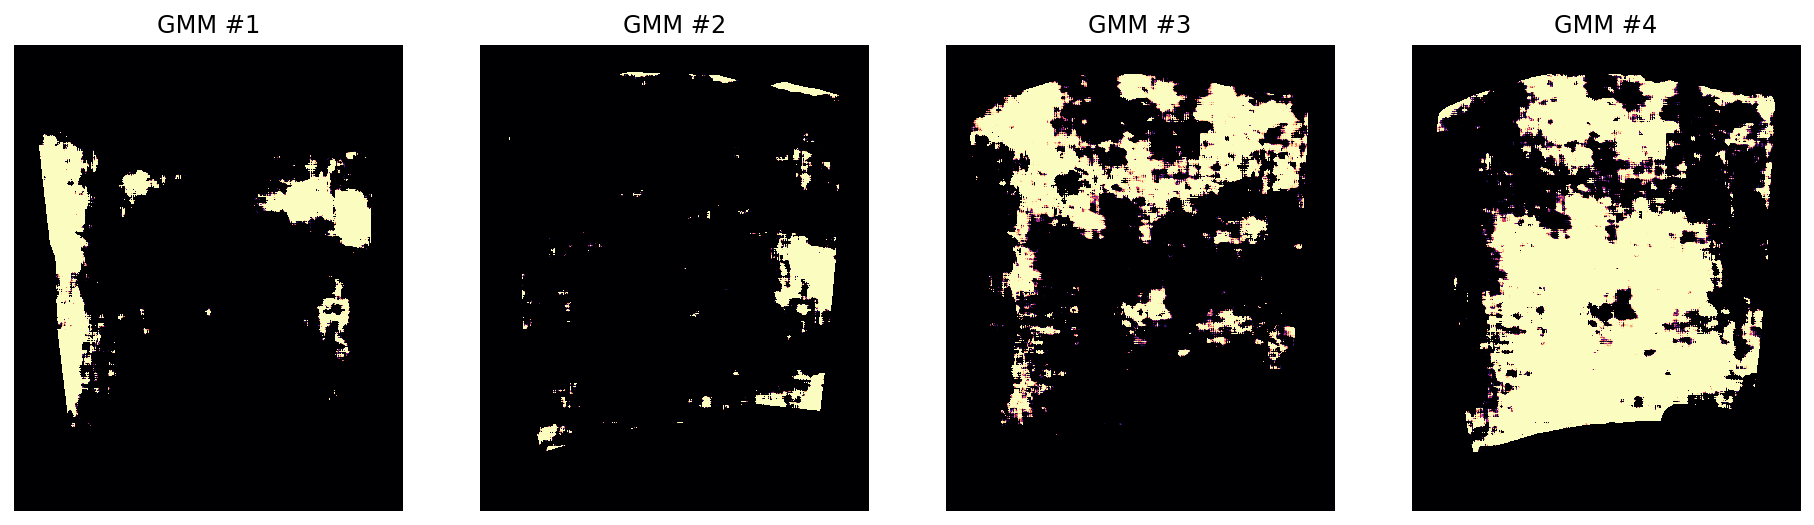

In [26]:
nn = len(gmm_stack_0359)
ff = plt.figure(figsize=(16,5))
for ii in range(nn):
    plt.subplot(1,nn,ii+1)
    plt.imshow(np.flipud(gmm_stack_0359[ii,:,4100:].T),cmap='magma')
    plt.axis('off')
    plt.title('GMM #'+str(ii+1))

(-0.5, 1419.5, 1704.5, -0.5)

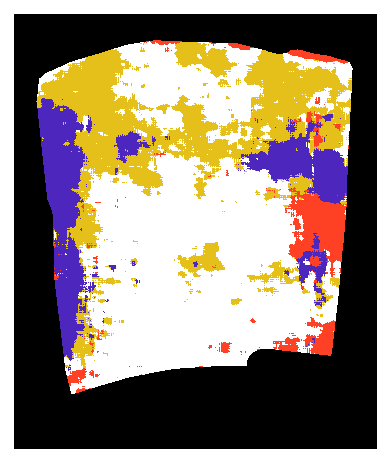

In [27]:
gmm_stack_0359_preds = np.argmax(gmm_stack_0359,axis=0) + 1
gmm_stack_0359_preds *= eroded_ctx_mask_0359
plt.imshow(np.flipud(gmm_stack_0359_preds[:,4100:].T),cmap='CMRmap')
plt.axis('off')

(-0.5, 1419.5, 1704.5, -0.5)

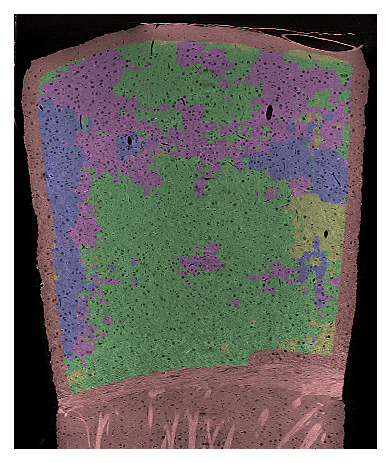

In [33]:
plt.imshow(np.flipud(img_overlay(gmm_stack_0359_preds[:,4100:].T,im_0359[:,4100:].T,0.3)))
plt.axis('off')

#### Calculate layer-wise distributions of signal

In [34]:
layer_mask_0259 = np.load(cc+'ctx_layers_anno.npy')
layer_mask_0359 = np.load('ctx_mask_0359.npy')

In [35]:
eroded_layer_mask_0259 = layer_mask_0259*eroded_mask_0259
eroded_layer_mask_0359 = layer_mask_0359*eroded_mask_0359

In [36]:
layer_names = ['L1','L2/3','L4','L5','L6']

In [37]:
def ctxGMMpreds2dist(gmm_preds,ctx_mask):
    n_classes = len(np.unique(gmm_preds))-1
    n_dist = len(np.unique(ctx_mask))-1
    dist_mat = np.zeros((n_classes,n_dist))
    for ii in range(n_classes):
        fact = gmm_preds==ii+1
        fact_sum = np.sum(fact)
        for jj in range(n_dist):
            mask = ctx_mask==jj+1
            dist_mat[ii,jj] = np.sum(mask*fact)/fact_sum
    return dist_mat

In [38]:
dist_gmm_0259 = ctxGMMpreds2dist(gmm_stack_0259_preds,eroded_layer_mask_0259)
dist_gmm_0359 = ctxGMMpreds2dist(gmm_stack_0359_preds,eroded_layer_mask_0359)

In [39]:
def plotDists(dist_mat,labels=layer_names):
    nf = dist_mat.shape[0]
    ff = plt.figure(figsize=(4*nf,4))
    for ii in range(nf):
        plt.subplot(1,nf,ii+1)
        sns.barplot(x=labels,y=dist_mat[ii],palette='Set2')
        plt.ylim(0,1)

Text(0.5, 0.98, 'Distributions for Gaussians in CTX 0259')

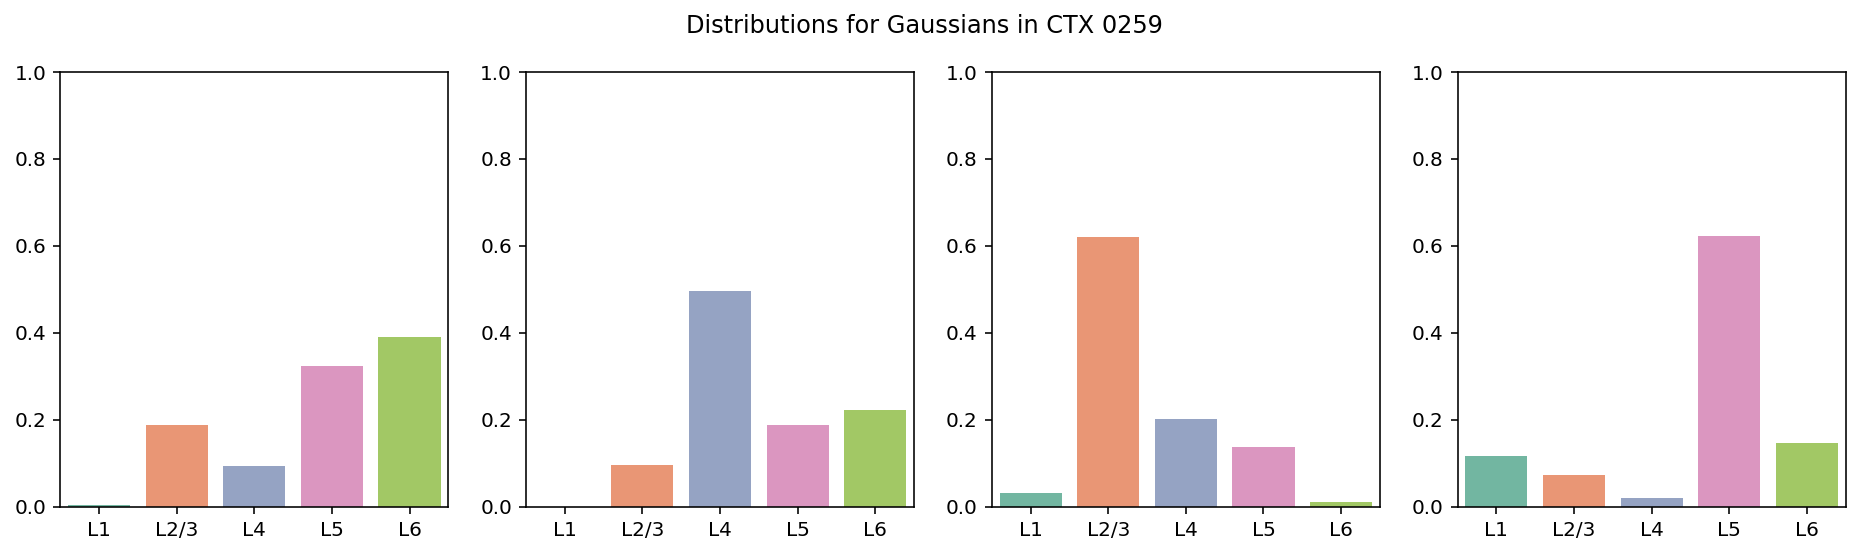

In [40]:
plotDists(dist_gmm_0259)
plt.suptitle('Distributions for Gaussians in CTX 0259')

Text(0.5, 0.98, 'Distributions for Gaussians in CTX 0359')

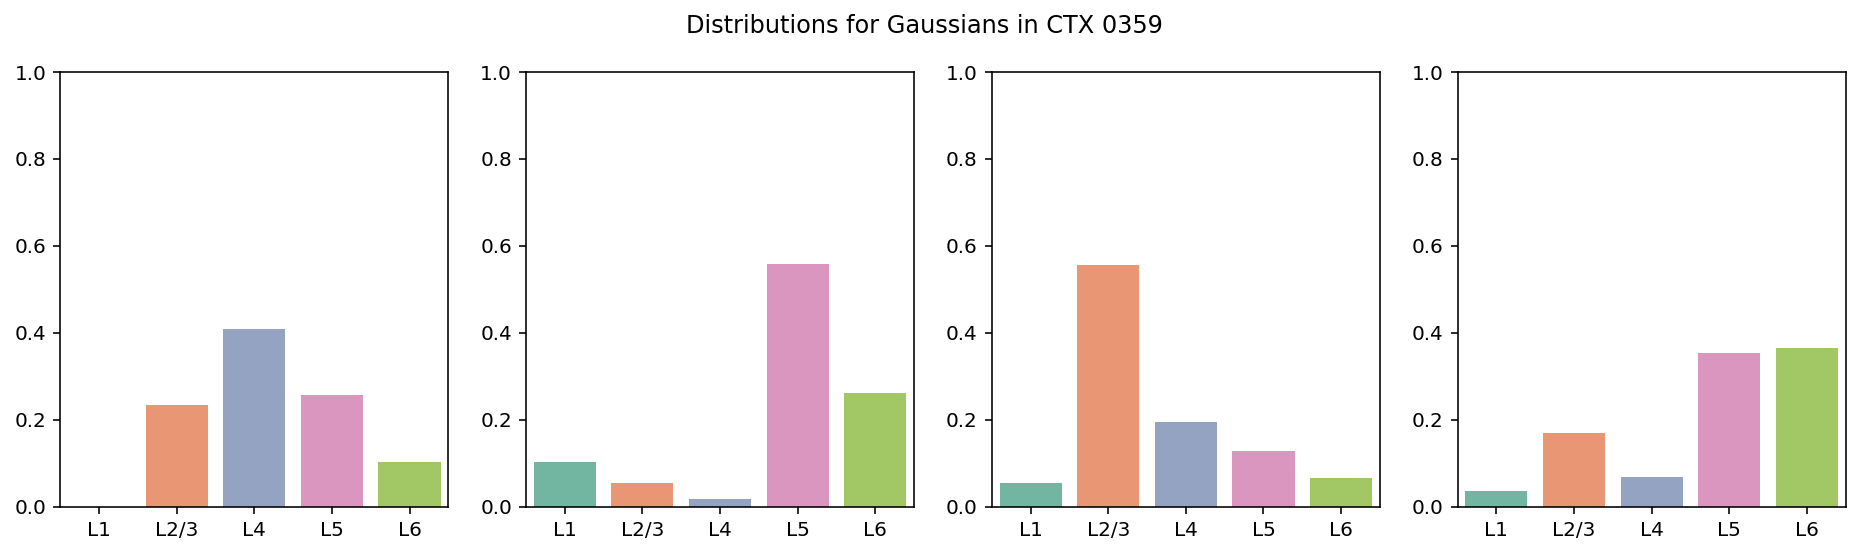

In [41]:
plotDists(dist_gmm_0359)
plt.suptitle('Distributions for Gaussians in CTX 0359')

#### Match distributions across imgs 0259 and 0359

In [42]:
def distDiffs(source_dist_mat,target_dist_mat,offset=1e-8):
    source_dist_mat += offset
    target_dist_mat += offset
    nn = source_dist_mat.shape[0]
    distances = np.zeros((nn,nn))
    for ii in range(nn):
        for jj in range(nn):
            distances[ii,jj] = jensenshannon(source_dist_mat[ii],target_dist_mat[jj])
    return distances

In [43]:
distances_gmm4_0259_0359 = distDiffs(dist_gmm_0259,dist_gmm_0359)

In [44]:
new_order_0359 = np.argmin(distances_gmm4_0259_0359,axis=1)

In [45]:
def MatchGMMs(new_order,target_stack):
    new_stack = np.zeros_like(target_stack)
    for ii in range(target_stack.shape[0]):
        new_stack[ii] = target_stack[new_order[ii]]
    return new_stack

In [46]:
reordered_gmm_stack_0359 = MatchGMMs(new_order_0359,gmm_stack_0359)

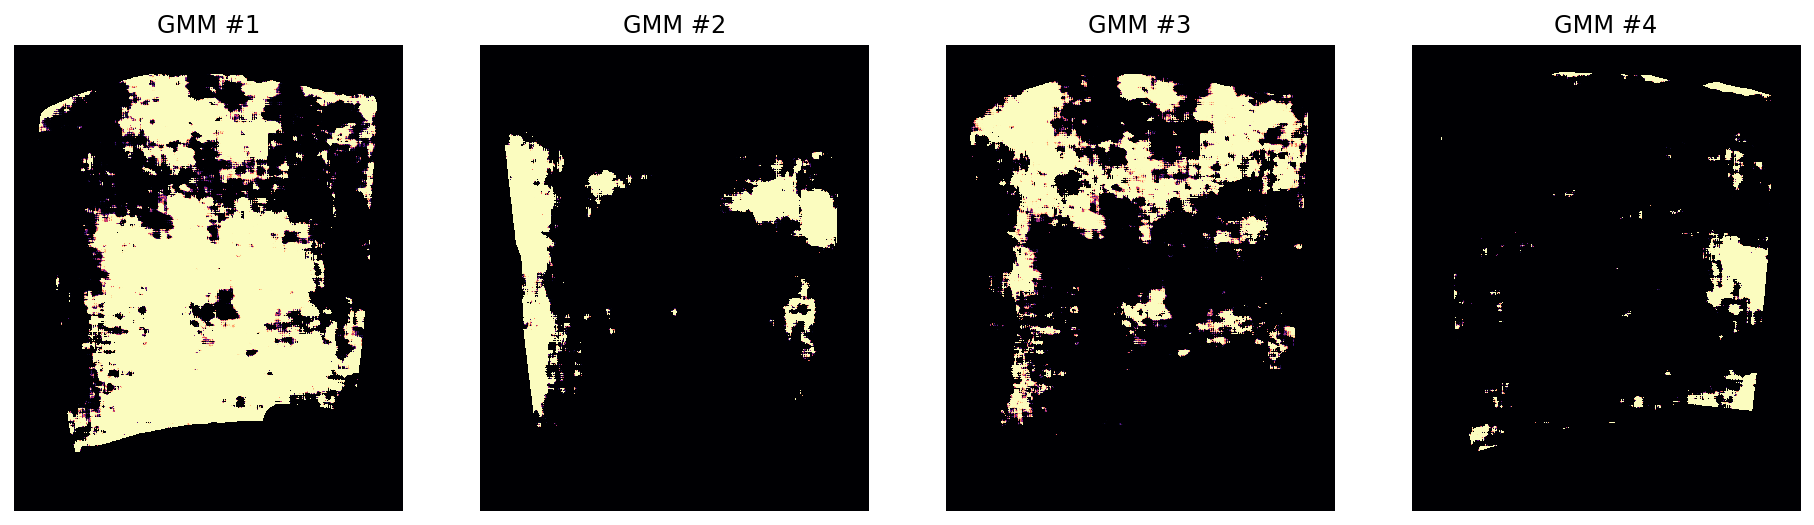

In [47]:
nn = len(reordered_gmm_stack_0359)
ff = plt.figure(figsize=(16,5))
for ii in range(nn):
    plt.subplot(1,nn,ii+1)
    plt.imshow(np.flipud(reordered_gmm_stack_0359[ii,:,4100:].T),cmap='magma')
    plt.axis('off')
    plt.title('GMM #'+str(ii+1))

(-0.5, 1419.5, 1704.5, -0.5)

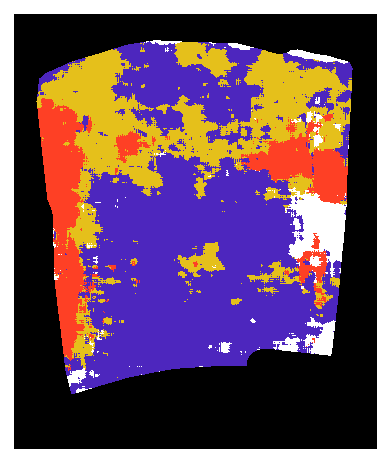

In [48]:
reordered_gmm_stack_0359_preds = np.argmax(reordered_gmm_stack_0359,axis=0) + 1
reordered_gmm_stack_0359_preds *= eroded_ctx_mask_0359
plt.imshow(np.flipud(reordered_gmm_stack_0359_preds[:,4100:].T),cmap='CMRmap')
plt.axis('off')

In [49]:
reordered_dist_gmm_0359 = ctxGMMpreds2dist(reordered_gmm_stack_0359_preds,eroded_layer_mask_0359)

Text(0.5, 0.98, 'Re-ordered Distributions for Gaussians in CTX 0359')

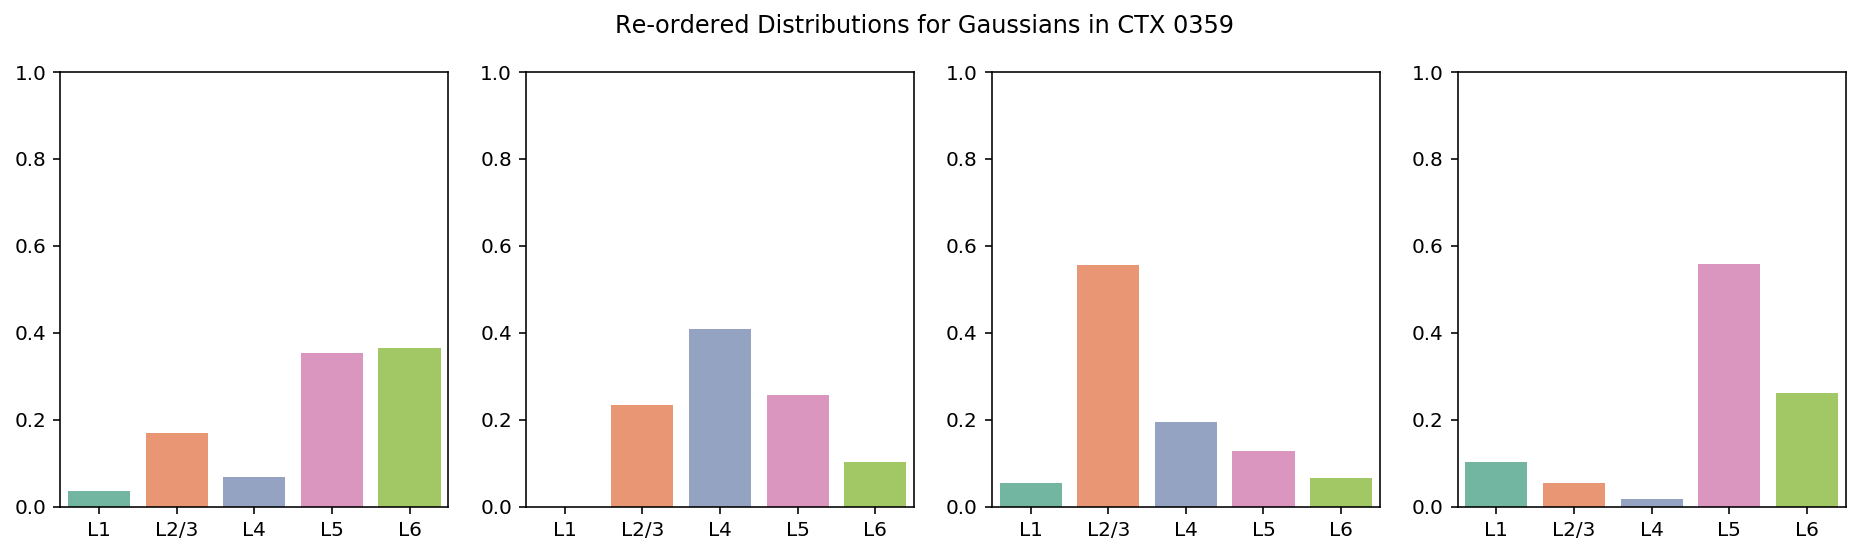

In [50]:
plotDists(reordered_dist_gmm_0359)
plt.suptitle('Re-ordered Distributions for Gaussians in CTX 0359')

#### Plot double-bar distribution plots

In [52]:
dataset_list = ['0259']*5 + ['0359']*5
layers_list = layer_names*2

In [53]:
def lists2gmm_data(probs1,probs2,dlist=dataset_list,llist=layers_list):
    probs_combo = np.hstack((probs1,probs2))
    d = {'Probabilities': probs_combo, 'Image': dlist, 'Layer': llist}
    df = pd.DataFrame(data=d)
    return df

In [54]:
df_gmm1 = lists2gmm_data(dist_gmm_0259[0],reordered_dist_gmm_0359[0])
df_gmm2 = lists2gmm_data(dist_gmm_0259[1],reordered_dist_gmm_0359[1])
df_gmm3 = lists2gmm_data(dist_gmm_0259[2],reordered_dist_gmm_0359[2])
df_gmm4 = lists2gmm_data(dist_gmm_0259[3],reordered_dist_gmm_0359[3])

Text(0.5, 1.0, 'GMM 4')

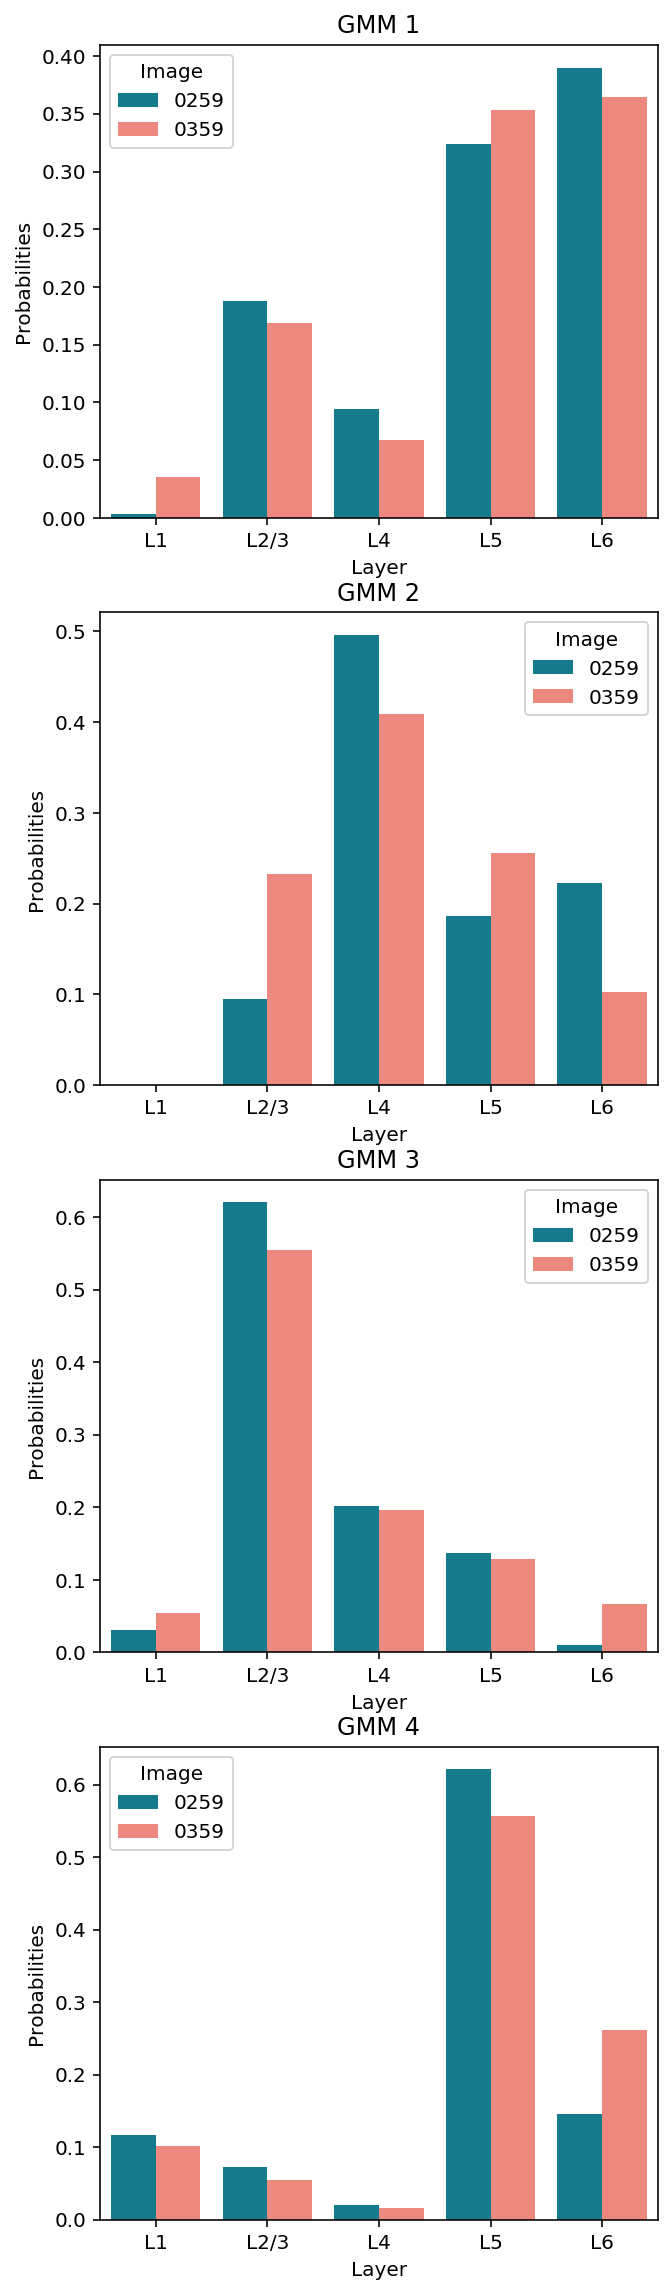

In [55]:
flatui = ["teal blue","salmon"]

fff = plt.figure(figsize=(5,20))

plt.subplot(411)
sns.barplot(x="Layer", y="Probabilities", hue="Image", data=df_gmm1, palette=sns.xkcd_palette(flatui))
plt.title('GMM 1')

plt.subplot(412)
sns.barplot(x="Layer", y="Probabilities", hue="Image", data=df_gmm2, palette=sns.xkcd_palette(flatui))
plt.title('GMM 2')

plt.subplot(413)
sns.barplot(x="Layer", y="Probabilities", hue="Image", data=df_gmm3, palette=sns.xkcd_palette(flatui))
plt.title('GMM 3')

plt.subplot(414)
sns.barplot(x="Layer", y="Probabilities", hue="Image", data=df_gmm4, palette=sns.xkcd_palette(flatui))
plt.title('GMM 4')

#### Plot arranged GMM plots combined

Text(0.5, 1.0, 'GMM #4')

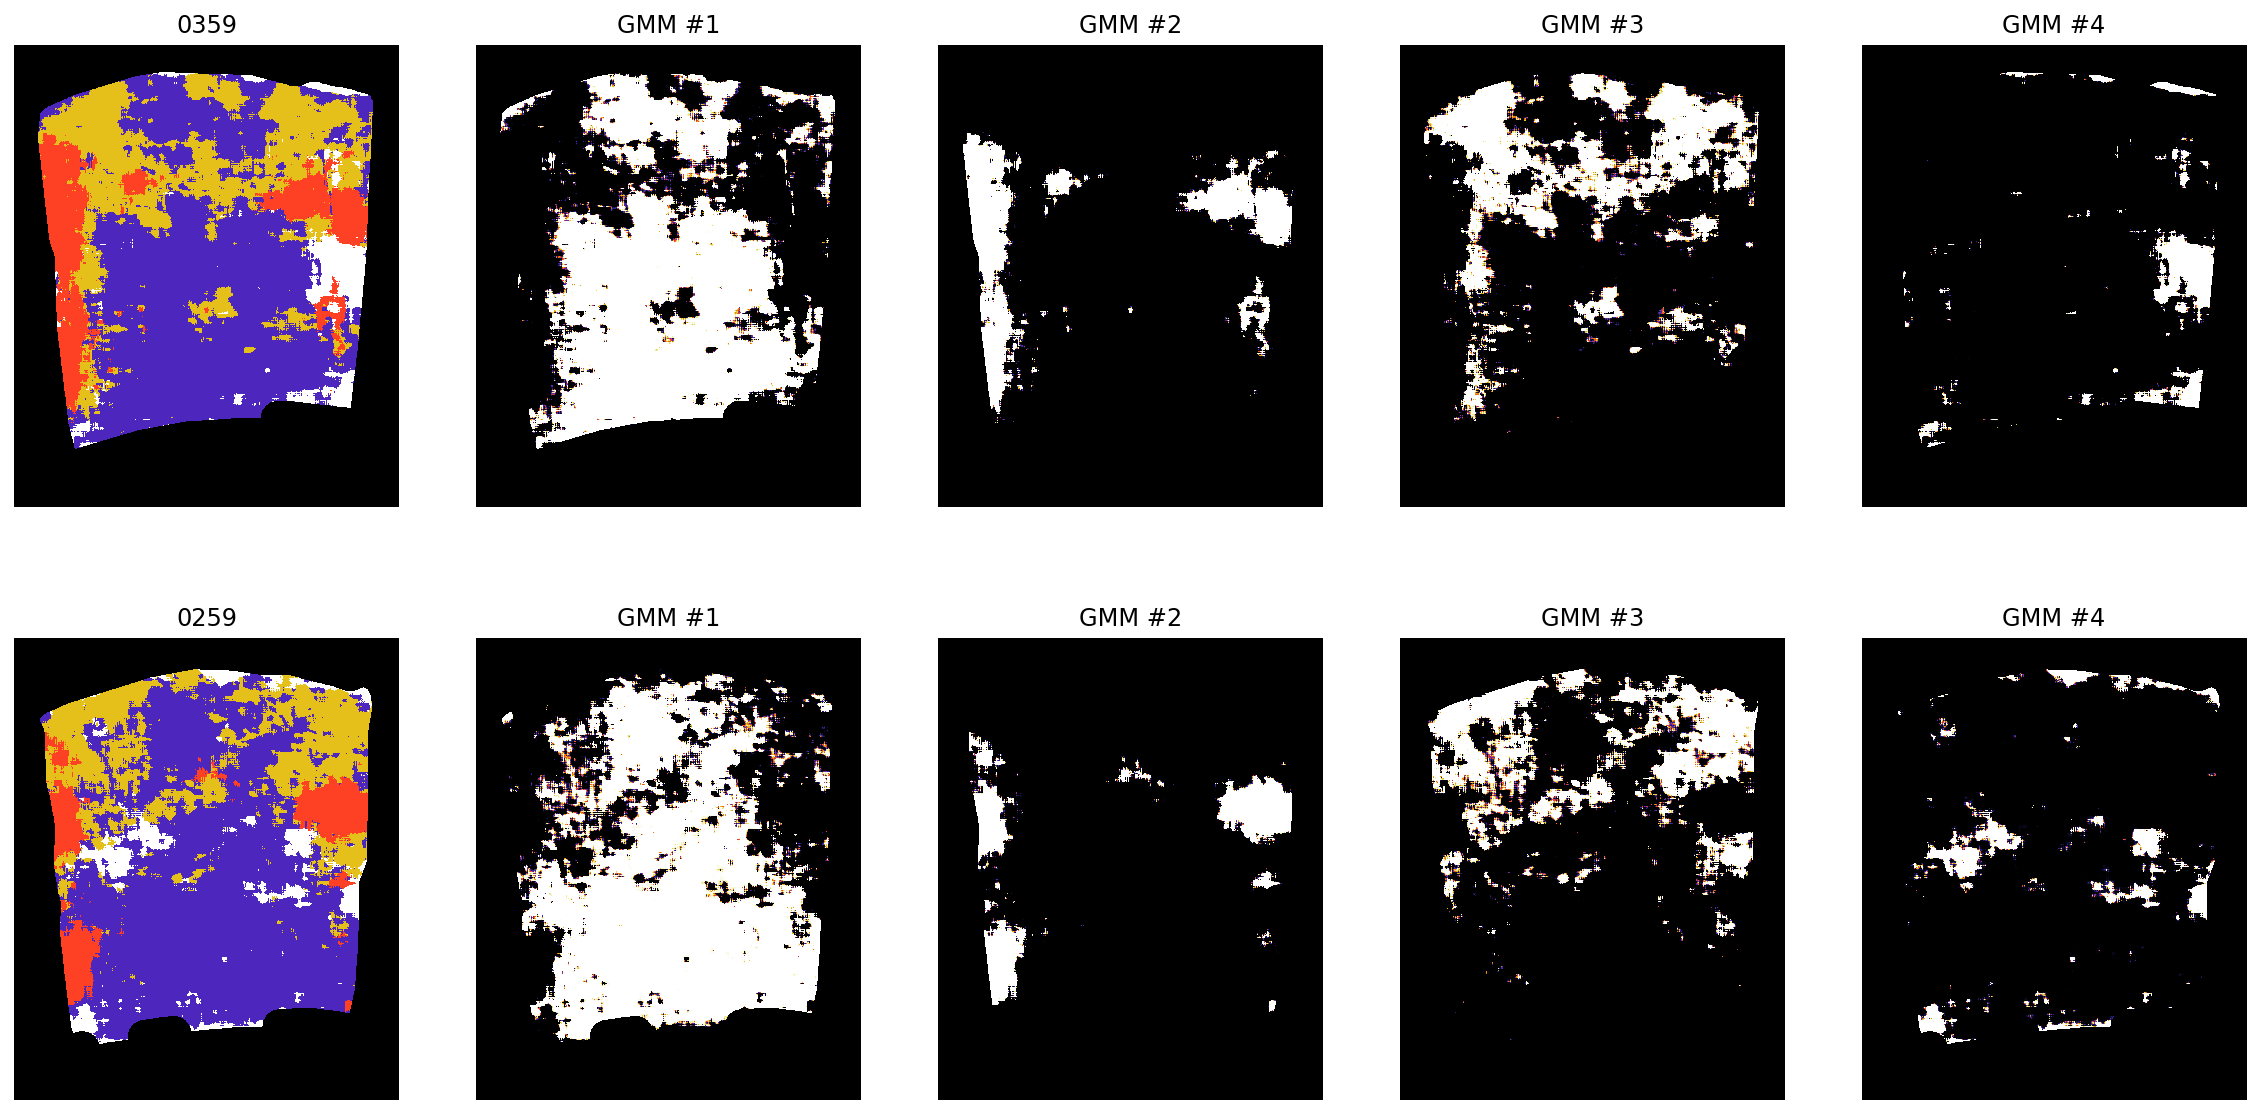

In [56]:
cmap='CMRmap'
ff = plt.figure(figsize=(20,10))

plt.subplot(2,5,1)
plt.imshow(np.flipud(reordered_gmm_stack_0359_preds[:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('0359')

plt.subplot(2,5,2)
plt.imshow(np.flipud(reordered_gmm_stack_0359[0,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(0+1))

plt.subplot(2,5,3)
plt.imshow(np.flipud(reordered_gmm_stack_0359[1,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(1+1))

plt.subplot(2,5,4)
plt.imshow(np.flipud(reordered_gmm_stack_0359[2,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(2+1))

plt.subplot(2,5,5)
plt.imshow(np.flipud(reordered_gmm_stack_0359[3,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(3+1))

plt.subplot(2,5,6)
plt.imshow(np.flipud(gmm_stack_0259_preds[:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('0259')

plt.subplot(2,5,7)
plt.imshow(np.flipud(gmm_stack_0259[0,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(0+1))

plt.subplot(2,5,8)
plt.imshow(np.flipud(gmm_stack_0259[1,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(1+1))

plt.subplot(2,5,9)
plt.imshow(np.flipud(gmm_stack_0259[2,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(2+1))

plt.subplot(2,5,10)
plt.imshow(np.flipud(gmm_stack_0259[3,:,4100:].T),cmap=cmap)
plt.axis('off')
plt.title('GMM #'+str(3+1))

#### Zoom into a patch (0259)

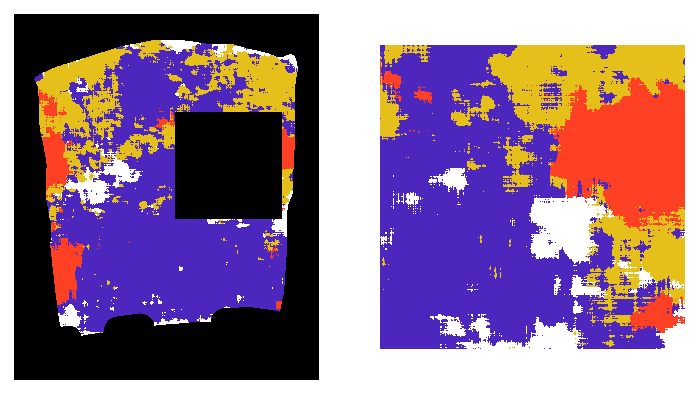

In [57]:
cp = gmm_stack_0259_preds.copy()
cp[750:1250,4850:5350] = 0
pp = gmm_stack_0259_preds[750:1250,4850:5350].copy()

plt.subplot(121)
plt.imshow(np.flipud(cp[:,4100:].T),cmap=cmap)
plt.axis('off')
plt.clim(0,4)

plt.subplot(122)
plt.imshow(np.flipud(pp.T),cmap=cmap)
plt.axis('off')
plt.clim(0,4)

In [58]:
big_patch = im_0259[750:1250,4850:5350]

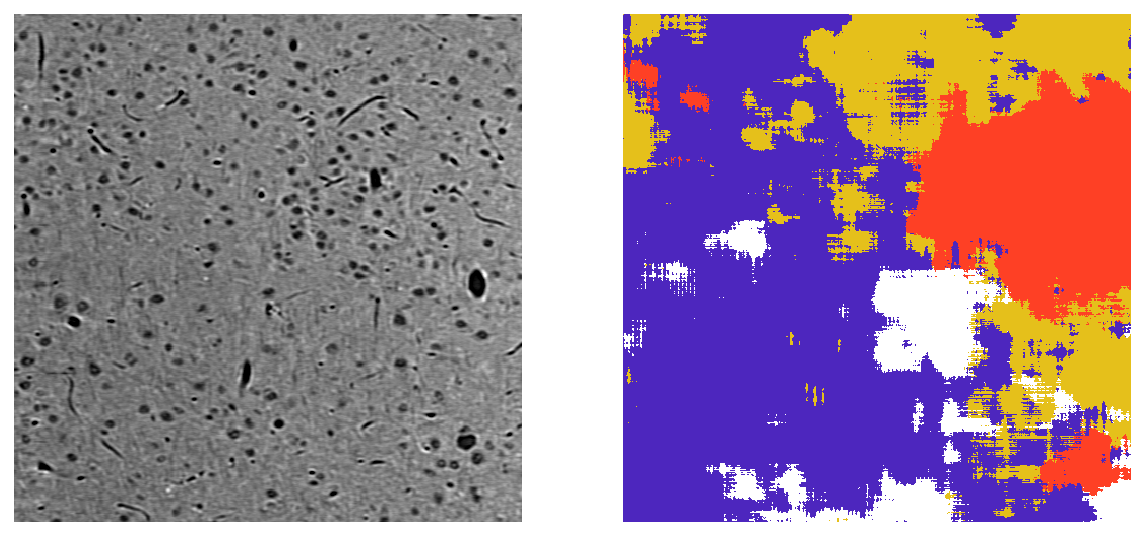

In [59]:
f = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.flipud(big_patch.T),cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.flipud(pp.T),cmap=cmap)
plt.axis('off')
plt.clim(0,4)

In [60]:
pretty_patch = np.flipud(big_patch.copy().T)
patch_mask = np.flipud(gmm_stack_0259_preds[750:1250,4850:5350].copy().T)

In [61]:
ps0,ps1 = patch_mask.shape
nc = len(np.unique(patch_mask))
stacked_ctx_factors = np.zeros((ps0,ps1,nc))
for ii in range(nc):
    stacked_ctx_factors[:,:,ii] = patch_mask==(ii+1)

(-0.5, 499.5, 499.5, -0.5)

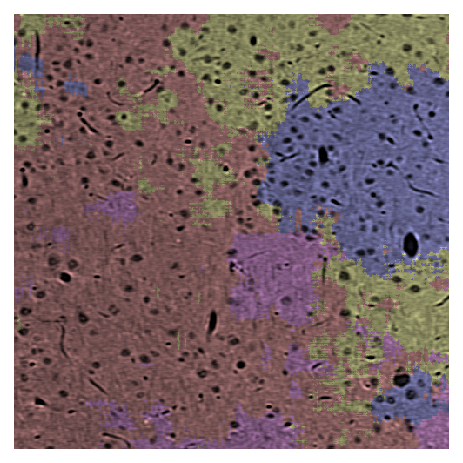

In [62]:
plt.imshow(img_overlay(np.flipud(gmm_stack_0259_preds[750:1250,4850:5350].T),pretty_patch,0.3))
plt.axis('off')